In [277]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib 
import seaborn as sns
import plotly.express as px



In [278]:

df= pd.read_csv('layoffs.csv')

print(df.head())
print(df.shape)

      company       location   industry  total_laid_off  percentage_laid_off  \
0      Amazon        Seattle     Retail          8000.0                 0.02   
1  Salesforce    SF Bay Area      Sales          8000.0                 0.10   
2       Vimeo  New York City   Consumer             NaN                 0.11   
3     Harappa      New Delhi  Education            60.0                 0.30   
4   ByteDance       Shanghai   Consumer             NaN                 0.10   

         date     stage        country  funds_raised  
0  2023-01-04       IPO  United States         108.0  
1  2023-01-04       IPO  United States          65.0  
2  2023-01-04       IPO  United States         450.0  
3  2023-01-03  Acquired          India           NaN  
4  2023-01-03   Unknown          China        9400.0  
(1860, 9)


In [279]:
# look for NA's
df.isna().sum()

company                  0
location                 0
industry                 6
total_laid_off         565
percentage_laid_off    605
date                     1
stage                    4
country                  0
funds_raised           141
dtype: int64

In [280]:
# check for duplicates
df[df.duplicated()]

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised
1003,Cazoo,London,Transportation,750.0,0.15,2022-06-07,IPO,United Kingdom,2000.0


In [281]:
# Remove duplicates
df.drop_duplicates(inplace=True)

In [282]:
# Deal with industry Naans by doing a google search
df[df['industry'].isnull()]

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised
107,DataRails,Tel Aviv,NaN,30.0,0.18,2022-12-05,Series B,Israel,103.0
139,Motional,Boston,NaN,NaN,NaN,2022-11-30,Unknown,United States,NaN
151,Proton.ai,Boston,NaN,NaN,NaN,2022-11-29,Series A,United States,20.0
261,InfluxData,SF Bay Area,NaN,65.0,0.27,2022-11-10,Series D,United States,119.0
275,AvantStay,Los Angeles,NaN,144.0,0.22,2022-11-09,Private Equity,United States,686.0
306,Exodus,Nebraska City,NaN,59.0,0.22,2022-11-04,Unknown,United States,60.0


In [283]:
# filling in industry NA's with correct data
df.loc[df['company']=='DataRails','industry'] = 'Finance'
df.loc[df['company']=='Motional','industry'] = 'Transportation'
df.loc[df['company']=='Proton.ai','industry'] = 'Sales'
df.loc[df['company']=='InfluxData','industry'] = 'Product'
df.loc[df['company']=='AvantStay','industry'] = 'Travel'
df.loc[df['company']=='Exodus','industry'] = 'Crypto'

In [284]:
# Filling in the 4 stage column NA's with unknown
df['stage'] = df['stage'].fillna('Unknown')

In [285]:
# looking at the observation with the NA in the date variable
df[df['date'].isnull()]

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised
1859,Homebound,SF Bay Area,Real Estate,NaN,NaN,NaN,Unknown,United States,128.0


In [286]:
# removing Homebound observation since it has too much missing data'
df = df[df.company != 'Homebound']

In [287]:
# convert date column to panda datetime series and add month and column rows
df['date'] = df['date'].apply(pd.to_datetime)
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['Month_Year'] = df['date'].apply(lambda x: x.strftime('%B-%Y')) 
df

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised,month,year,Month_Year
0,Amazon,Seattle,Retail,8000.0,0.02,2023-01-04,IPO,United States,108.0,1,2023,January-2023
1,Salesforce,SF Bay Area,Sales,8000.0,0.10,2023-01-04,IPO,United States,65.0,1,2023,January-2023
2,Vimeo,New York City,Consumer,NaN,0.11,2023-01-04,IPO,United States,450.0,1,2023,January-2023
3,Harappa,New Delhi,Education,60.0,0.30,2023-01-03,Acquired,India,NaN,1,2023,January-2023
4,ByteDance,Shanghai,Consumer,NaN,0.10,2023-01-03,Unknown,China,9400.0,1,2023,January-2023
...,...,...,...,...,...,...,...,...,...,...,...,...
1854,Service,Los Angeles,Travel,NaN,1.00,2020-03-16,Seed,United States,5.1,3,2020,March-2020
1855,HopSkipDrive,Los Angeles,Transportation,8.0,0.10,2020-03-13,Unknown,United States,45.0,3,2020,March-2020
1856,Panda Squad,SF Bay Area,Consumer,6.0,0.75,2020-03-13,Seed,United States,1.0,3,2020,March-2020
1857,Tamara Mellon,Los Angeles,Retail,20.0,0.40,2020-03-12,Series C,United States,90.0,3,2020,March-2020


In [288]:

# # removing all rows that have NA in both columns(total_laid_off and percentage_laid_off)

bothNA = df[["total_laid_off", "percentage_laid_off"]].isnull().all(axis=1) 
df = df.loc[~bothNA, :]
df

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised,month,year,Month_Year
0,Amazon,Seattle,Retail,8000.0,0.02,2023-01-04,IPO,United States,108.0,1,2023,January-2023
1,Salesforce,SF Bay Area,Sales,8000.0,0.10,2023-01-04,IPO,United States,65.0,1,2023,January-2023
2,Vimeo,New York City,Consumer,NaN,0.11,2023-01-04,IPO,United States,450.0,1,2023,January-2023
3,Harappa,New Delhi,Education,60.0,0.30,2023-01-03,Acquired,India,NaN,1,2023,January-2023
4,ByteDance,Shanghai,Consumer,NaN,0.10,2023-01-03,Unknown,China,9400.0,1,2023,January-2023
...,...,...,...,...,...,...,...,...,...,...,...,...
1854,Service,Los Angeles,Travel,NaN,1.00,2020-03-16,Seed,United States,5.1,3,2020,March-2020
1855,HopSkipDrive,Los Angeles,Transportation,8.0,0.10,2020-03-13,Unknown,United States,45.0,3,2020,March-2020
1856,Panda Squad,SF Bay Area,Consumer,6.0,0.75,2020-03-13,Seed,United States,1.0,3,2020,March-2020
1857,Tamara Mellon,Los Angeles,Retail,20.0,0.40,2020-03-12,Series C,United States,90.0,3,2020,March-2020


In [289]:
# checking how many NA's are left
df.isna().sum()

company                  0
location                 0
industry                 0
total_laid_off         277
percentage_laid_off    317
date                     0
stage                    0
country                  0
funds_raised           106
month                    0
year                     0
Month_Year               0
dtype: int64

In [290]:
# If a company is missing either total laid off or percentage laid off it can be calculated if the company shows
# up again in the dataset AND has both values populated. First I need to calculate total number of employees
df['total_employees'] = df['total_laid_off']/df['percentage_laid_off']

/var/folders/37/_6bzmbwj16q021_3f7fq4yv40000gp/T/ipykernel_1543/3970917564.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [291]:
# How many inf, NA or zero values in total employees

print(f" The number of total_employees observations with NA values is {sum(df.total_employees.isna())}")
print(f" The number of total_employees observations with inf values is {np.isinf(df['total_employees']).values.sum()}")
print(f" The number of total_employee observations with 0 total employees {(df['total_employees'] == 0).sum()}")

 The number of total_employees observations with NA values is 594
 The number of total_employees observations with inf values is 1
 The number of total_employee observations with 0 total employees 0


In [292]:
# replacing inf values with NA
df = df.replace([np.inf, -np.inf], np.nan)

In [293]:
# If company total employees column has an NA Im going to fill it with the value from a differrent row where the total
# employee value is not an NA
df['total_employees'] = df['total_employees'].fillna(df.groupby('company')['total_employees'].transform('mean'))

In [294]:
# fill the percentage_laid_off NA values with total_laid_off values divided by total_employees values for companies
# where I know the total amount of employees
df['percentage_laid_off'] = df.apply(
    lambda row: row['total_laid_off']/row['total_employees'] if np.isnan(row['percentage_laid_off']) else row['percentage_laid_off'],
    axis=1
)

In [295]:
df.isna().sum() # percentage_laid_off no has 70 less NA values (317-247)

company                  0
location                 0
industry                 0
total_laid_off         277
percentage_laid_off    247
date                     0
stage                    0
country                  0
funds_raised           106
month                    0
year                     0
Month_Year               0
total_employees        502
dtype: int64

In [296]:
# fill the total_laid_off NA values with percentage_laid_off values multiplied by total_employees values for companies
# where I know the total amount of employees
df['total_laid_off'] = df.apply(
    lambda row: row['percentage_laid_off']*row['total_employees'] if np.isnan(row['total_laid_off']) else row['total_laid_off'],
    axis=1
)

In [297]:
df.isna().sum() #total laid off now has 23 less NA values (277-254)

company                  0
location                 0
industry                 0
total_laid_off         254
percentage_laid_off    247
date                     0
stage                    0
country                  0
funds_raised           106
month                    0
year                     0
Month_Year               0
total_employees        502
dtype: int64

In [298]:
df.describe

<bound method NDFrame.describe of             company        location        industry  total_laid_off  \
0            Amazon         Seattle          Retail          8000.0   
1        Salesforce     SF Bay Area           Sales          8000.0   
2             Vimeo   New York City        Consumer             NaN   
3           Harappa       New Delhi       Education            60.0   
4         ByteDance        Shanghai        Consumer             NaN   
...             ...             ...             ...             ...   
1854        Service     Los Angeles          Travel             NaN   
1855   HopSkipDrive     Los Angeles  Transportation             8.0   
1856    Panda Squad     SF Bay Area        Consumer             6.0   
1857  Tamara Mellon     Los Angeles          Retail            20.0   
1858       EasyPost  Salt Lake City       Logistics            75.0   

      percentage_laid_off       date     stage        country  funds_raised  \
0                   0.020 2023-01-

In [299]:
#Checking the data types
df.dtypes

company                        object
location                       object
industry                       object
total_laid_off                float64
percentage_laid_off           float64
date                   datetime64[ns]
stage                          object
country                        object
funds_raised                  float64
month                           int64
year                            int64
Month_Year                     object
total_employees               float64
dtype: object

In [300]:
# changing the month and year columns to objects for categorical visualizations
df['year'] = df['year'].astype(str)
df['month'] = df['month'].astype(str)

In [301]:
# making a copy of the dataframe before I work with remaing NA's
df2 = df.copy()

In [302]:
# dropping rows with Na's
df2 = df2.dropna()

In [303]:
df2.isna().sum()

company                0
location               0
industry               0
total_laid_off         0
percentage_laid_off    0
date                   0
stage                  0
country                0
funds_raised           0
month                  0
year                   0
Month_Year             0
total_employees        0
dtype: int64

In [ ]:
# most of the visualizations will be focusing on the total number laid off so I will drop the observations
# that have NA in this variable 
df_total= df.dropna(subset=['total_laid_off'])


In [306]:
df_total.dtypes

company                        object
location                       object
industry                       object
total_laid_off                float64
percentage_laid_off           float64
date                   datetime64[ns]
stage                          object
country                        object
funds_raised                  float64
month                          object
year                           object
Month_Year                     object
total_employees               float64
dtype: object

In [408]:
# Ill also be creating visuals focusing on the percentage laid off and will create another dataframe
df_perc= df.dropna(subset=['percentage_laid_off'])

In [105]:
# one more where total employee Na rows are removed
# df_emp= df2.dropna(subset=['total_employees'])

In [308]:
df_total.dtypes

company                        object
location                       object
industry                       object
total_laid_off                float64
percentage_laid_off           float64
date                   datetime64[ns]
stage                          object
country                        object
funds_raised                  float64
month                          object
year                           object
Month_Year                     object
total_employees               float64
dtype: object

In [307]:
# Look at layoffs by year

df_layoffs_year = df_total.groupby('year',as_index=False)['total_laid_off'].sum()
fig = px.bar(df_layoffs_year, x='year',y='total_laid_off',
       template = 'simple_white',
       title="Layoffs by Year",
       labels={'year': '', 'total_laid_off':'Total Layoffs'})

fig.update_layout(title_x=0.5)

In [311]:
fig = px.scatter(df_total, x="date", y="total_laid_off",
                 template = 'ggplot2',
                 labels={
                     "date": "",
                     "total_laid_off": "Amount of Layoffs"
                 },
                title="Layoffs from 2020 until 2023")
fig.update_xaxes(
    dtick="M11",)

fig.show()

In [329]:
# Layoffs by month

fig = px.bar(df_total.sort_values(by='date', ascending=True),
             x='Month_Year',
             y="total_laid_off",
             template = 'simple_white',
             title="Layoff Timeline",
             labels={'Month_Year': '', 'total_laid_off':'Total Layoffs'})
fig.update_layout(title_x=0.5)
fig.show()

In [380]:
# look at data when grouped by year and industry
df_ind_yr = df_total.groupby(['industry', 'year']).sum() 
df_ind_yr = df_ind_yr.reset_index()


fig = px.bar(df_ind_yr.sort_values(by=['total_laid_off'], ascending=False), x="industry", y="total_laid_off",
             color='year', barmode='group',
             height=700,
            template = 'ggplot2',
             title="Layoffs by Year and Industry",
             labels={'industry': 'Industry', 'total_laid_off':'Total Layoffs'})
fig.update_layout(title_x=0.5)
fig.show()

In [381]:
fig = px.bar(df_ind_yr.sort_values(by=['total_laid_off'], ascending=False), x="industry", y="total_laid_off",
             color='year',
             height=700,
            template = 'ggplot2',
             title="Layoffs by Year and Industry",
             labels={'industry': 'Industry', 'total_laid_off':'Total Layoffs'})
fig.update_layout(title_x=0.5)
fig.show()

In [393]:
# Look at 2020 compared to 2022



fig = px.bar(df_total[(df_total['year'] == '2020') | (df_total['year'] == '2022')].sort_values(by=['total_laid_off'],
             ascending=False), 
             x="industry",
             y="total_laid_off",
             color='year', barmode='group',
             height=700,
             template = 'ggplot2',
             title="Layoffs by Year and Industry",
             labels={'industry': 'Industry', 'total_laid_off':'Total Layoffs'})
fig.update_layout(title_x=0.5)
fig.show()

In [400]:
# There is only a few weeks in Jan so ill add those layoffs to 2022 to see if it changes the outcome much

df_23is22 = df_total.copy()
df_23is22['year'].mask(df_23is22['year'] == '2023', '2022', inplace=True)
df2_20_23 = df_23is22[df_23is22['year'] != '2021']
df2_20_23.year.unique()

array(['2022', '2020'], dtype=object)

In [489]:
fig = px.bar(df_23is22[(df_23is22['year'] == '2020') | (df_23is22['year'] == '2022')].sort_values(by=['total_laid_off'],
             ascending=False), 
             x="industry",
             y="total_laid_off",
             color='year', barmode='group',
             height=700,
             template = 'ggplot2',
             title="Layoffs by Year and Industry (Adding 2023 Data to 2022)",
             labels={'industry': 'Industry', 'total_laid_off':'Total Layoffs'})
fig.update_layout(title_x=0.5)
fig.show()

In [419]:
# take a look at the distribution of the percentage of layoffs in a company.  If a company is laying
# laying off a small percentage of their staff they could just be letting go of their worst performers
fig = px.box(df_perc, x="year", y="percentage_laid_off")
fig.show()

In [500]:
df_perc.percentage_laid_off.unique().dir()

AttributeError: 'numpy.ndarray' object has no attribute 'dir'

In [501]:
fig = px.violin(df_perc, x="year", y="percentage_laid_off", box = True, points = 'all')
fig.show()

# df = px.data.tips()
# fig = px.violin(df, y="tip", x="smoker", color="sex", box=True, points="all",
#           hover_data=df.columns)
# fig.show()


In [428]:
fig = px.box(df_perc, x="stage", y="percentage_laid_off")
fig.show()

In [432]:
fig = px.box(df_perc, x="country", y="percentage_laid_off")
fig.show()

In [ ]:
# look at the number of layoffs per location
df2_layoffs_loc = df2.groupby('location',as_index=False)['total_laid_off'].sum().sort_values('total_laid_off',ascending=False).head(15)
fig = px.bar(df2_layoffs_loc,x='location', y='total_laid_off',text_auto='.3s',title='Total Employees laid off in each location')
fig.update_traces(textfont_size=12, textangle=0, textposition='outside')

In [440]:
# look at the number of layoffs per location and limit it to the top 15 cities
df_layoffs_loc = df_total.groupby('location',as_index=False)['total_laid_off'].sum().sort_values('total_laid_off',ascending=False).head(15)
fig = px.bar(df_layoffs_loc,x='location', y='total_laid_off',text_auto='.4s',title='Employees Laid Off by City')
fig.update_traces( textposition='outside')

In [442]:
df_total[['company']].nunique()

company    1095
dtype: int64

In [456]:
df.groupby(['industry', 'year'])[['company']].nunique()

company
industry       year         
Aerospace      2020        3
               2022        2
Construction   2020        5
               2021        1
               2022        3
...                      ...
Transportation 2020       39
               2021        1
               2022       44
Travel         2020       39
               2022        8

[76 rows x 1 columns]

In [450]:
df_layoffs_co.dtypes

industry    object
company      int64
dtype: object

In [490]:
# look at the number companies in each industry that had layoffs
df_layoffs_co = df.groupby('industry')[['company']].nunique().sort_values('company',ascending=False)
df_layoffs_co = df_layoffs_co.reset_index()
fig = px.bar(df_layoffs_co,x='industry', y='company',title='Number of Companies with Layoffs by Industry')
fig.update_traces( textposition='outside')

In [457]:
df_layoffs_co_yr = df.groupby(['industry', 'year'])[['company']].nunique().sort_values('company',ascending=False)
df_layoffs_co_yr = df_layoffs_co_yr.reset_index()
fig = px.bar(df_layoffs_co_yr.sort_values(by=['company'], ascending=False), x="industry", y="company",
             color='year',
             height=700,
            template = 'ggplot2',
             title="Layoffs by Year and Industry",
             labels={'industry': 'Industry', 'total_laid_off':'Total Layoffs'})
fig.update_layout(title_x=0.5)
fig.show()

In [461]:
df_co_yr = df.groupby(['company', 'year'])[['total_laid_off']].sum().sort_values('total_laid_off',ascending=False).head(20)
df_co_yr = df_co_yr.reset_index()
fig = px.bar(df_co_yr.sort_values(by=['total_laid_off'], ascending=False), x="company", y="total_laid_off",
             color='year',
             height=700,
            template = 'ggplot2',
             title="Layoffs of top 20 Companies by Year",
             labels={'industry': 'Industry', 'total_laid_off':'Total Layoffs'})
fig.update_layout(title_x=0.5)
fig.show()

In [486]:
df_ind_yr = df_total.groupby(['industry', 'year']).sum() 
df_ind_yr = df_ind_yr.reset_index()
fig = px.pie(df_ind_yr[df_ind_yr['year'].str.contains('2020')], values='total_laid_off', names='industry', title='Amount of Layoffs by Industry')
fig.show()

In [487]:
df_ind_yr = df_total.groupby(['industry', 'year']).sum() 
df_ind_yr = df_ind_yr.reset_index()
fig = px.pie(df_ind_yr[df_ind_yr['year'].str.contains('2022')], values='total_laid_off', names='industry', title='Amount of Layoffs by Industry')
fig.show()

In [485]:
df_ind = df_total.groupby(['industry']).sum() 
df_ind = df_ind_yr.reset_index()
fig = px.pie(df_ind_yr, values='total_laid_off', names='industry', title='Amount of Layoffs by Industry')
fig.show()

In [462]:
fig = px.bar(df_total[df_total['industry'].str.contains('Travel')].sort_values(by='date', ascending=True), x='year', y="percentage_laid_off")
fig.show()

In [ ]:
fig = px.scatter(df.query("year==2007"), x="gdpPercap", y="lifeExp",
    size="pop", color="continent",
                 hover_name="country", log_x=True, size_max=60)
fig.show()

In [469]:
fig = px.scatter(df2, x="date",  y="percentage_laid_off",
                 size="total_laid_off",
                 template = 'ggplot2',
                 labels={
                     "date": "",
                     "total_laid_off": "Amount of Layoffs"
                 },
                title="Layoffs from 2020 until 2023")
fig.update_xaxes(
    dtick="M11",)

fig.show()

In [470]:
fig = px.scatter(df2[df2['industry'].str.contains('Food')], x="date",  y="percentage_laid_off",
                 size="total_laid_off",
                 template = 'ggplot2',
                 labels={
                     "date": "",
                     "total_laid_off": "Amount of Layoffs"
                 },
                title="Layoffs in the Food Industry from 2020 until 2023")
fig.update_xaxes(
    dtick="M11",)

fig.show()

In [471]:
fig = px.scatter(df2[df2['industry'].str.contains('Travel')], x="date",  y="percentage_laid_off",
                 size="total_laid_off",
                 template = 'ggplot2',
                 labels={
                     "date": "",
                     "total_laid_off": "Amount of Layoffs"
                 },
                title="Layoffs in the Travel Industry from 2020 until 2023")
fig.update_xaxes(
    dtick="M11",)

fig.show()

In [472]:
fig = px.scatter(df2[df2['industry'].str.contains('Crypto')], x="date",  y="percentage_laid_off",
                 size="total_laid_off",
                 template = 'ggplot2',
                 labels={
                     "date": "",
                     "total_laid_off": "Amount of Layoffs"
                 },
                title="Layoffs in the Crypto Industry from 2020 until 2023")
fig.update_xaxes(
    dtick="M11",)

fig.show()

In [473]:
fig = px.scatter(df2[df2['industry'].str.contains('Education')], x="date",  y="percentage_laid_off",
                 size="total_laid_off",
                 template = 'ggplot2',
                 labels={
                     "date": "",
                     "total_laid_off": "Amount of Layoffs"
                 },
                title="Layoffs in the Education Industry from 2020 until 2023")
fig.update_xaxes(
    dtick="M11",)

fig.show()

In [474]:
fig = px.scatter(df2[df2['industry'].str.contains('Healthcare')], x="date",  y="percentage_laid_off",
                 size="total_laid_off",
                 template = 'ggplot2',
                 labels={
                     "date": "",
                     "total_laid_off": "Amount of Layoffs"
                 },
                title="Layoffs in the Healthcare Industry from 2020 until 2023")
fig.update_xaxes(
    dtick="M11",)

fig.show()

In [475]:
fig = px.scatter(df2[df2['industry'].str.contains('Recruiting')], x="date",  y="percentage_laid_off",
                 size="total_laid_off",
                 template = 'ggplot2',
                 labels={
                     "date": "",
                     "total_laid_off": "Amount of Layoffs"
                 },
                title="Layoffs in the Recruiting Industry from 2020 until 2023")
fig.update_xaxes(
    dtick="M11",)

fig.show()

In [488]:
fig = px.scatter(df2[df2['industry'].str.contains('Real Estate')], x="date",  y="percentage_laid_off",
                 size="total_laid_off",
                 template = 'ggplot2',
                 labels={
                     "date": "",
                     "total_laid_off": "Amount of Layoffs"
                 },
                title="Layoffs in the Real Estate Industry from 2020 until 2023")
fig.update_xaxes(
    dtick="M11",)

fig.show()

In [479]:
fig = px.scatter(df2[df2['industry'].str.contains('Transportation')], x="date",  y="percentage_laid_off",
                 size="total_laid_off",
                 template = 'ggplot2',
                 labels={
                     "date": "",
                     "total_laid_off": "Amount of Layoffs"
                 },
                title="Layoffs in the Transportation Industry from 2020 until 2023")
fig.update_xaxes(
    dtick="M11",)

fig.show()

In [372]:
fig = px.bar(df[df['industry'].str.contains('Food')].sort_values(by='date', ascending=True), x='year', y="percentage_laid_off")
fig.show()

In [36]:
fig = px.bar(df[df['industry'].str.contains('Food')].sort_values(by='date', ascending=True), x='Month_Year', y="total_laid_off")
fig.show()


In [37]:
fig = px.bar(df[df['industry'].str.contains('Consumer')].sort_values(by='date', ascending=True), x='year', y="percentage_laid_off")
fig.show()

In [38]:
fig = px.bar(df[df['industry'].str.contains('Consumer')].sort_values(by='date', ascending=True), x='year', y="total_laid_off")
fig.show()

In [39]:
fig = px.bar(df[df['industry'].str.contains('Real Estate')].sort_values(by='date', ascending=True), x='Month_Year', y="percentage_laid_off")
fig.show()

In [40]:
fig = px.bar(df[df['industry'].str.contains('Real Estate')].sort_values(by='date', ascending=True), x='year', y="total_laid_off")
fig.show()

In [41]:
fig = px.bar(df[df['industry'].str.contains('Healthcare')].sort_values(by='date', ascending=True), x='year', y="percentage_laid_off")
fig.show()

In [42]:
fig = px.bar(df[df['industry'].str.contains('Healthcare')].sort_values(by='date', ascending=True), x='year', y="total_laid_off")
fig.show()

In [46]:
df

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised,month,year,Month_Year
0,Amazon,Seattle,Retail,8000.0,0.02,2023-01-04,IPO,United States,108.0,1,2023,January-2023
1,Salesforce,SF Bay Area,Sales,8000.0,0.10,2023-01-04,IPO,United States,65.0,1,2023,January-2023
2,Vimeo,New York City,Consumer,NaN,0.11,2023-01-04,IPO,United States,450.0,1,2023,January-2023
3,Harappa,New Delhi,Education,60.0,0.30,2023-01-03,Acquired,India,NaN,1,2023,January-2023
4,ByteDance,Shanghai,Consumer,NaN,0.10,2023-01-03,Unknown,China,9400.0,1,2023,January-2023
...,...,...,...,...,...,...,...,...,...,...,...,...
1854,Service,Los Angeles,Travel,NaN,1.00,2020-03-16,Seed,United States,5.1,3,2020,March-2020
1855,HopSkipDrive,Los Angeles,Transportation,8.0,0.10,2020-03-13,Unknown,United States,45.0,3,2020,March-2020
1856,Panda Squad,SF Bay Area,Consumer,6.0,0.75,2020-03-13,Seed,United States,1.0,3,2020,March-2020
1857,Tamara Mellon,Los Angeles,Retail,20.0,0.40,2020-03-12,Series C,United States,90.0,3,2020,March-2020


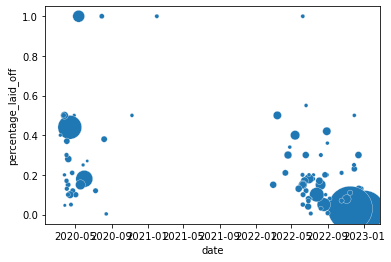

In [107]:
# libraries
# import matplotlib.pyplot as plt
# import seaborn as sns


# data
#data = gapminder.loc[gapminder.year == 2007]

# use the scatterplot function to build the bubble map
sns.scatterplot(data= df_emp.loc[df_emp['industry'] == 'Retail'], x="date", y="percentage_laid_off", size="total_laid_off", legend=False, sizes=(10, 2000))

# show the graph
plt.show()

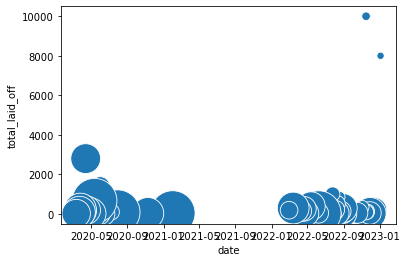

In [38]:
# use the scatterplot function to build the bubble map
sns.scatterplot(data= df_emp.loc[df_emp['industry'] == 'Retail'], x="date", y="total_laid_off", size="percentage_laid_off", legend=False, sizes=(20, 2000))

# show the graph
plt.show()